In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import pycatch22 as catch22
import palettable
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer, MinMaxScaler, PowerTransformer
from scipy.spatial import distance
import pickle as pkl
from sklearn.metrics import pairwise_distances
from scipy import stats
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import sdeint
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')


## Euclidean Distance Comparison

Load in extracted features from training data

In [18]:
with open('features_combined.pkl', 'rb') as f:
    FEATURES_COMBINED = pkl.load(f)

Generate test points from Hopf System in Fixed Point Regime

In [62]:
np.random.seed(0)
mus = [-1, -0.9, -0.5, -0.1]
#mus = [1, 1.1, 1.5, 1.9]
etas = [0.1, 0.8] # low and high noise for comparison
num_samples = 50
sols_list = list()
dt = 0.01
tspan = np.arange(0, 55, dt)
eta_list = list()
mu_list = list()
for eta in etas:
    for mu in mus:
        def f(state, t):
            x, y = state[0], state[1]
            dxdt = -y + (mu - x **2 - y**2) * x
            dydt = x + (mu - x ** 2 - y **2) * y
            return dxdt, dydt
        for i in range(num_samples):
            ic = np.array(np.random.uniform(size=2)) # uniform random initial conditions
            gw = lambda y, t: eta * np.identity(ic.shape[0]) # noise is relative to ic's 
            fw = lambda y, t: np.array(f(y,t))
            sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
            sols_list.append(sol[500:]) # cut out first 500 time points
            eta_list.append(eta)
            mu_list.append(mu)

KeyboardInterrupt: 

Bistable test

In [69]:
np.random.seed(6)
mus = [-0.3, -0.1, 0, 0.5]
#mus = [1, 1.1, 1.5, 1.9]
etas = [0.1, 0.8] # low and high noise for comparison
num_samples = 50
sols_list = list()
dt = 0.01
tspan = np.arange(0, 55, dt)
eta_list = list()
mu_list = list()
for eta in etas:
    for mu in mus:
        def f(state, t):
            x = state
            dxdt = mu + x - x**3
            return dxdt 
        for i in range(num_samples):
            ic = np.array([np.random.uniform()]) # uniform random initial conditions
            gw = lambda y, t: eta * np.identity(ic.shape[0]) # noise is relative to ic's 
            fw = lambda y, t: np.array(f(y,t))
            sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
            sols_list.append(sol[500:]) # cut out first 500 time points
            eta_list.append(eta)
            mu_list.append(mu)

In [70]:
TS_test = np.array([sols_list[i][:,0] for i in range(len(sols_list))]) # extract x component
FEATURES_test = np.array([catch22.catch22_all(TS_test[i,:])['values'] for i in range(len(sols_list))])

In [44]:
FEATURES_test.shape

(400, 22)

---------------

Define each of the transformations and return a dataframe of embeddings

In [71]:
def standard():
    ss = StandardScaler()
    ss.fit(FEATURES_COMBINED) # fit training data
    ss_scaled = ss.transform(FEATURES_COMBINED)
    pca_reducer = PCA(n_components=2)
    pca_reducer.fit(ss_scaled)
    embedding_standard = pca_reducer.transform(ss_scaled)
    
    # project test points
    ss_scaled_test = ss.transform(FEATURES_test)
    test_embedding = pca_reducer.transform(ss_scaled_test)
    df_test_pts = pd.DataFrame(test_embedding)
    df_test_pts['mu'] = mu_list
    df_test_pts['eta'] = eta_list

    return df_test_pts

def ScaledRobustSigmoid(theta=1.35):
    rs = RobustScaler() # robust scaler
    rs.fit(FEATURES_COMBINED)
    rs_scaled = rs.transform(FEATURES_COMBINED)
    def sigmoid(x, theta):
        return 1/(1+np.exp(-theta*x))
    sigmoid_transformer = FunctionTransformer(sigmoid, kw_args={'theta': theta}) # define custom function for sigmoid transformation
    sigmoid_transformer.fit(rs_scaled)
    sigmoid_rs = sigmoid_transformer.transform(rs_scaled)
    ss = StandardScaler() # standard scaler
    ss.fit(sigmoid_rs)
    ss_sigmoid_rs = ss.transform(sigmoid_rs)
    pca_reducer = PCA(n_components=2)
    pca_reducer.fit(ss_sigmoid_rs)
    embedding_robustSigmoid = pca_reducer.transform(ss_sigmoid_rs)

    # project test points
    rs_scaled_test = rs.transform(FEATURES_test)
    sigmoid_rs_scaled_test = sigmoid_transformer.transform(rs_scaled_test)
    ss_sig_robust_test = ss.transform(sigmoid_rs_scaled_test)
    test_embedding = pca_reducer.transform(ss_sig_robust_test)
    df_test_pts = pd.DataFrame(test_embedding)
    df_test_pts['mu'] = mu_list
    df_test_pts['eta'] = eta_list

    return df_test_pts

def MinMaxrobustSigmoid(theta=1.35):
    rs = RobustScaler() # robust scaler
    rs.fit(FEATURES_COMBINED)
    rs_scaled = rs.transform(FEATURES_COMBINED)
    def sigmoid(x, theta):
        return 1/(1+np.exp(-theta*x))
    sigmoid_transformer = FunctionTransformer(sigmoid, kw_args={'theta': theta}) # define custom function for sigmoid transformation
    sigmoid_transformer.fit(rs_scaled)
    sigmoid_rs = sigmoid_transformer.transform(rs_scaled)
    mm = MinMaxScaler() # standard scaler
    mm.fit(sigmoid_rs)
    mm_sigmoid_rs = mm.transform(sigmoid_rs)
    pca_reducer = PCA(n_components=2)
    pca_reducer.fit(mm_sigmoid_rs)
    embedding_robustSigmoid = pca_reducer.transform(mm_sigmoid_rs)

    # project test points
    rs_scaled_test = rs.transform(FEATURES_test)
    sigmoid_rs_scaled_test = sigmoid_transformer.transform(rs_scaled_test)
    mm_sig_robust_test = mm.transform(sigmoid_rs_scaled_test)
    test_embedding = pca_reducer.transform(mm_sig_robust_test)
    df_test_pts = pd.DataFrame(test_embedding)
    df_test_pts['mu'] = mu_list
    df_test_pts['eta'] = eta_list

    return df_test_pts

def BoxCox():
    transformer = PowerTransformer(method='yeo-johnson')
    transformer.fit(FEATURES_COMBINED)
    box_cox_transformed = transformer.transform(FEATURES_COMBINED)
    ss = StandardScaler()
    ss.fit(box_cox_transformed)
    ss_boxcox = ss.transform(box_cox_transformed)
    pca_reducer_box = PCA(n_components=2)
    pca_reducer_box.fit(ss_boxcox)
    embedding_box = pca_reducer_box.transform(ss_boxcox)

    # project test points
    transformed_test = transformer.transform(FEATURES_test)
    scaled_box_test = ss.transform(transformed_test)
    test_embedding = pca_reducer_box.transform(scaled_box_test)
    
    df_test_pts = pd.DataFrame(test_embedding)
    df_test_pts['mu'] = mu_list
    df_test_pts['eta'] = eta_list

    return df_test_pts


In [72]:
std = standard()
srs = ScaledRobustSigmoid()
mmrs = MinMaxrobustSigmoid(theta=1.0)
bc = BoxCox()

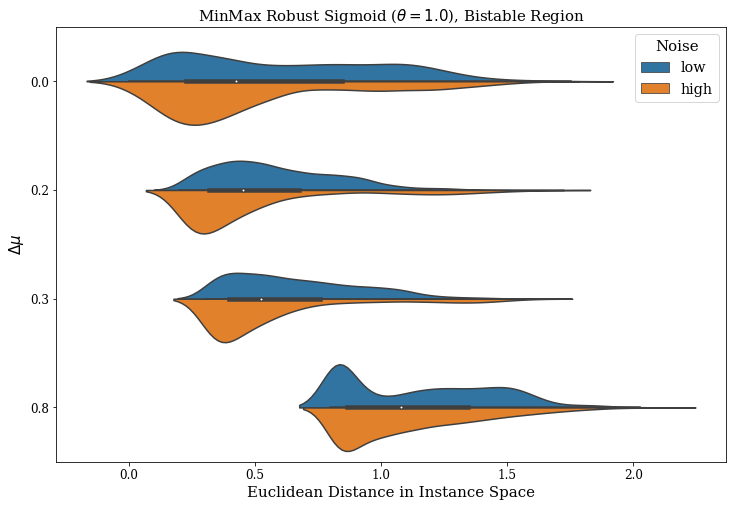

In [76]:
plt.figure(figsize=(12,8))
distances_list = list()
deltas_list = list()
noise_list = list()

transformation = mmrs

for mu in mus:
    distances_low = pairwise_distances(transformation[(transformation['mu'] == -0.3) & (transformation['eta'] == 0.1)], transformation[(transformation['mu'] == mu) & (transformation['eta'] == 0.1)], metric='euclidean').reshape(-1,)
    distances_list.append(distances_low)
    delta = np.round(np.abs(-0.3 - mu),2)
    deltas_list.append(np.tile(delta, len(distances_low)))
    noise_list.append(np.tile('low', len(distances_low)))

    distances_high = pairwise_distances(transformation[(transformation['mu'] == -0.3) & (transformation['eta'] == 0.8)], transformation[(transformation['mu'] == mu) & (transformation['eta'] == 0.8)], metric='euclidean').reshape(-1,)
    distances_list.append(distances_high)
    deltas_list.append(np.tile(delta, len(distances_low)))
    noise_list.append(np.tile('high', len(distances_low)))
    #distances = distances[distances != 0]

distances = np.array([distances_list[i] for i in range(len(distances_list))]).reshape(20000,1)
deltas = np.array([deltas_list[i] for i in range(len(deltas_list))]).reshape(20000,1)
noise = np.array([noise_list[i] for i in range(len(noise_list))]).reshape(20000,1)
datasave = pd.DataFrame(distances, columns=['dist'])
datasave['delta'] = deltas
datasave['noise'] = noise

sns.violinplot(data=datasave, x='dist', orient='h', y='delta', hue='noise', split=True)
plt.title(r'MinMax Robust Sigmoid ($\theta = 1.0$), Bistable Region', fontsize=15)
plt.ylabel(r'$\Delta \mu$', fontsize=15)
plt.legend(fontsize='x-large', title_fontsize='15').set_title('Noise')
plt.xlabel('Euclidean Distance in Instance Space', fontsize=15)
plt.show()

## Projection Test

Error metric - absolute error between ground truth control parameter and inferred control parameter using ABC method. Also comparison between ground truth system and predicted system.

In [132]:
np.random.seed(485)
mu = -1
#mus = [1, 1.1, 1.5, 1.9]
eta = 0.1
sols_list = list()
dt = 0.01
tspan = np.arange(0, 55, dt)
def f(state, t):
    x, y = state[0], state[1]
    dxdt = -y + (mu - x **2 - y**2) * x
    dydt = x + (mu - x ** 2 - y **2) * y
    return dxdt, dydt
ic = np.array(np.random.uniform(size=2)) # uniform random initial conditions
gw = lambda y, t: eta * np.identity(ic.shape[0]) # noise is relative to ic's 
fw = lambda y, t: np.array(f(y,t))
sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
sols_list.append(sol[500:]) # cut out first 500 time points

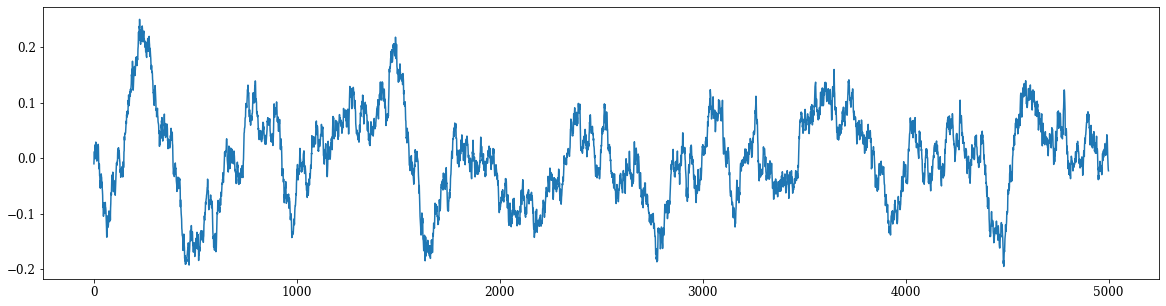

In [139]:
plt.figure(figsize=(20,5))
plt.plot(sols_list[0][:,0])
plt.show()

In [140]:
TS_new = sols_list[0][:,0]
FEATURES_new = np.array(catch22.catch22_all(TS_new)['values'])

In [143]:
rs = RobustScaler() # robust scaler
theta = 1.0
rs.fit(FEATURES_COMBINED)
rs_scaled = rs.transform(FEATURES_COMBINED)
def sigmoid(x, theta):
    return 1/(1+np.exp(-theta*x))
sigmoid_transformer = FunctionTransformer(sigmoid, kw_args={'theta': theta}) # define custom function for sigmoid transformation
sigmoid_transformer.fit(rs_scaled)
sigmoid_rs = sigmoid_transformer.transform(rs_scaled)
mm = MinMaxScaler() # standard scaler
mm.fit(sigmoid_rs)
mm_sigmoid_rs = mm.transform(sigmoid_rs)
pca_reducer = PCA(n_components=2)
pca_reducer.fit(mm_sigmoid_rs)
embedding_robustSigmoid = pca_reducer.transform(mm_sigmoid_rs)


In [146]:
rs_scaled_test = rs.transform(FEATURES_new.reshape(1,22))
sigmoid_rs_scaled_test = sigmoid_transformer.transform(rs_scaled_test)
mm_sig_robust_test = mm.transform(sigmoid_rs_scaled_test)
test_embedding = pca_reducer.transform(mm_sig_robust_test)

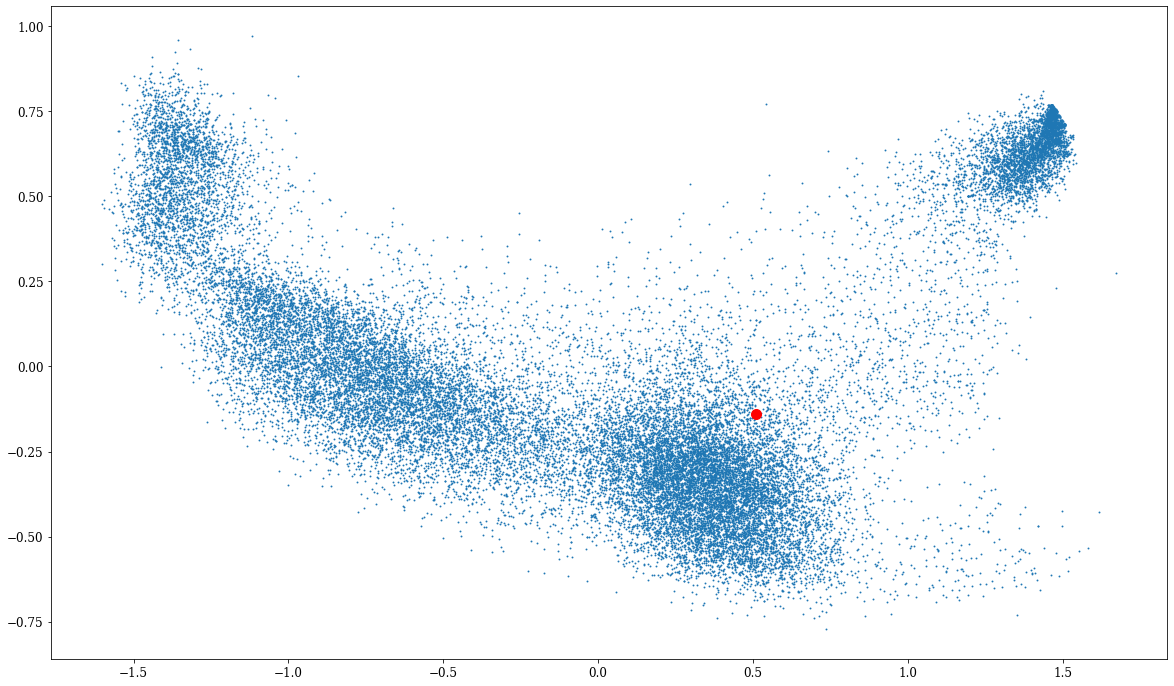

In [157]:
plt.figure(figsize=(20,12))
plt.scatter(embedding_robustSigmoid[:,0], embedding_robustSigmoid[:,1], s=0.8)
plt.scatter(test_embedding[:,0], test_embedding[:,1], s=100, c='r')
plt.show()